In [1]:
import os
import csv
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf

from sklearn.model_selection import train_test_split
import sklearn

from keras.layers.pooling import MaxPooling2D
from keras.layers.core import K
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, Cropping2D, Lambda, Dropout
from keras.callbacks import ModelCheckpoint

# Visualizations will be shown in the notebook.
%matplotlib inline

/Users/racheldam/opt/anaconda2/envs/myenv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/racheldam/opt/anaconda2/envs/myenv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/racheldam/opt/anaconda2/envs/myenv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/racheldam/opt/anac

In [2]:
#Loading data

data_path = './data/'
driving_log = './data/driving_log.csv'

In [3]:
def data_loading(driving_log, test_size):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            labels_file: The labels CSV file.
            test_size: The size of the testing set.
    """
    labels = pd.read_csv(driving_log)
    x = labels[['center', 'left', 'right']].values
    y = labels['steering'].values
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=test_size, random_state=0)

    return x_train, x_valid, y_train, y_valid

In [4]:
def image_loading(data_path, image_file):
    """
    Load RGB image.
        Parameters:
            data_dir: The directory where the images are.
            image_file: The image file name.
    """
    return mpimg.imread(os.path.join(data_path, image_file.strip()))

In [5]:
data = data_loading(driving_log, 0.2)

In [6]:
def display(image, angle, label):
    plt.imshow(image)
    plt.xlabel("Steering angle: {:.5f}".format(angle))
    plt.title(label)
    plt.xticks([])
    plt.yticks([])
    plt.show()

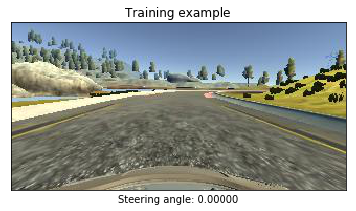

In [7]:
image = image_loading(data_path, str(data[0][0][0]))
steering_angle = data[2][0]
label = "Training example"
display(image, steering_angle, label)

In [8]:
#Data Pre-processing

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

def image_preprocess(img):
    """
    Preprocessing (Crop - Resize - Convert to YUV) the input image.
        Parameters:
            img: The input image to be preprocessed.
    """
    # Cropping the image
    img = img[60:-25, :, :]
    # Resizing the image
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
    # Converting the image to YUV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return img

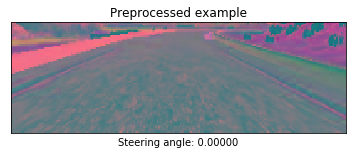

In [9]:
image = image_preprocess(image_loading(data_path, str(data[0][0][0])))
steering_angle = data[2][0]
label = "Preprocessed example"
display(image, steering_angle, label)

In [26]:
#Data Augmentation

def adjusting(data_path, center, left, right, steering_angle):
    """
    Adjusting the steering angle of random images.
        Parameters:
            data_dir: The directory where the images are.
            center: Center image.
            left: Left image.
            right: Right image
            steering_angle: The steering angle of the input frame.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return image_loading(data_path, left), steering_angle + 0.2
    elif choice == 1:
        return image_loading(data_path, right), steering_angle - 0.2
    return image_loading(data_path, center), steering_angle

In [27]:
def flipping(image, steering_angle):
    """
    Randomly flipping the input image horizontaly, with steering angle adjustment.
        Parameters:
            image: The input image.
            steering_angle: The steering angle related to the input image.
    """
#     if np.random.rand() < 0.5:
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

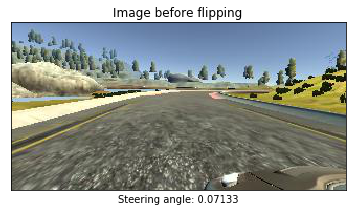

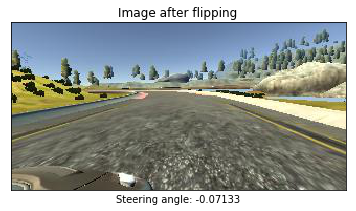

In [28]:
image = image_loading(data_path, str(data[0][0][1]))
steering_angle = data[2][1]
label = "Image before flipping"
display(image, steering_angle, label)

image = flipping(image, steering_angle)
label = "Image after flipping"
display(image[0], image[1], label)

In [29]:
def translation(image, steering_angle, range_x, range_y):
    """
    Shifting (Translating) the input images, with steering angle adjustment.
        Parameters:
            image: The input image.
            steering_angle: The steering angle related to the input image.
            range_x: Horizontal translation range.
            range_y: Vertival translation range.
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

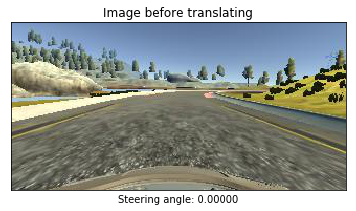

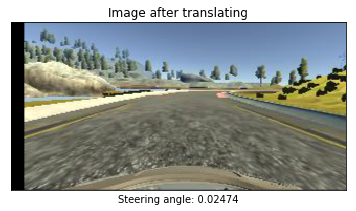

In [30]:
image = image_loading(data_path, str(data[0][0][0]))
steering_angle = data[2][0]
label = "Image before translating"
display(image, steering_angle, label)

image = translation(image, steering_angle, 100, 10)
label = "Image after translating"
display(image[0], image[1], label)

In [31]:
def shadowing(image):
    """
    Adding shadow to the input image.
        Parameters:
            image: The input image.
    """
    bright_factor = 0.3
    x = random.randint(0, image.shape[1])
    y = random.randint(0, image.shape[0])
    width = random.randint(image.shape[1], image.shape[1])
    if(x + width > image.shape[1]):
        x = image.shape[1] - x
    height = random.randint(image.shape[0], image.shape[0])
    if(y + height > image.shape[0]):
        y = image.shape[0] - y
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image[y:y+height,x:x+width,2] = image[y:y+height,x:x+width,2]*bright_factor
    return cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

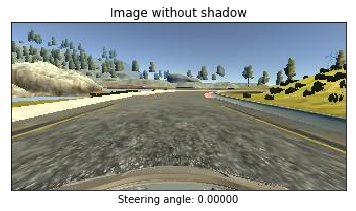

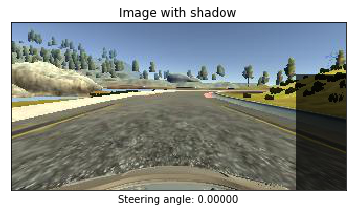

In [32]:
image = image_loading(data_path, str(data[0][0][0]))
steering_angle = data[2][0]
label = "Image without shadow"
display(image, steering_angle, label)

image = shadowing(image)
label = "Image with shadow"
display(image, steering_angle, label)

In [33]:
def brightness(image):
    """
    Altering the brightness of the input image.
        Parameters:
            image: The input image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

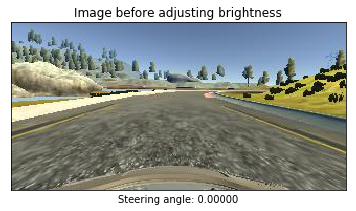

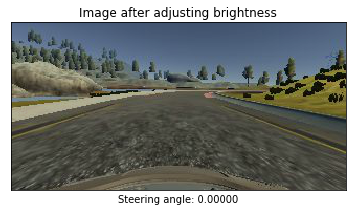

In [34]:
image = image_loading(data_path, str(data[0][0][0]))
steering_angle = data[2][0]
label = "Image before adjusting brightness"
display(image, steering_angle, label)

image = brightness(image)
label = "Image after adjusting brightness"
display(image, steering_angle, label)

In [35]:
def data_augmentation(data_path, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust the associated steering angle.
        Parameters:
            data_dir: The directory where the images are.
            center: Center image.
            left: Left image.
            right: Right image
            steering_angle: The steering angle related to the input frame.
            range_x (Default = 100): Horizontal translation range.
            range_y (Default = 10): Vertival translation range.
    """
    image, steering_angle = adjusting(data_path, center, left, right, steering_angle)
    image, steering_angle = flipping(image, steering_angle)
    image, steering_angle = translation(image, steering_angle, range_x, range_y)
    image = shadowing(image)
    image = brightness(image)
    return image, steering_angle

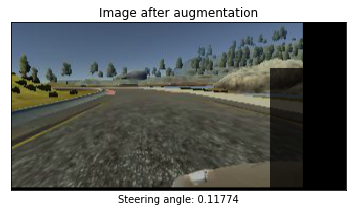

In [36]:
steering_angle = data[2][0]
center = data[0][0][0]
left = data[0][0][1]
right = data[0][0][2]
range_x = 100
range_y = 10

image, steering_angle = data_augmentation(data_path, center, left, right, steering_angle, range_x, range_y)
label = "Image after augmentation"
display(image, steering_angle, label)

In [37]:
#Model Architecture

def NVIDIA_net():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
    model.add(Conv2D(24, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Conv2D(36, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Conv2D(48, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.summary()
    return model

In [39]:
#Model Training and Evaluation

batch_size = 40
samples_per_epoch = 20000
nb_epoch = 10

In [40]:
def batching(data_path, image_paths, steering_angles, batch_size, training_flag):
    """
    Generate a training image given image paths and the associated steering angles
        Parameters:
            data_dir: The directory where the images are.
            image_paths: Paths to the input images.
            steering_angle: The steering angle related to the input frame.
            batch_size: The batch size used to train the model.
            training_flag: A flag to determine whether we're in training or validation mode.
    """
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            if training_flag and np.random.rand() < 0.6:
                image, steering_angle = data_augmentation(data_path, center, left, right, steering_angle)
            else:
                image = image_loading(data_path, center) 
            images[i] = image_preprocess(image)
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        yield images, steers

In [41]:
def model_training(model, x_train, x_valid, y_train, y_valid):
    checkpoint = ModelCheckpoint('model-{val_loss:03f}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')
    model.compile(loss='mse', optimizer=Adam(lr=1.0e-4))
    model.fit_generator(batching(data_path, x_train, y_train, batch_size, True),
                        samples_per_epoch,
                        nb_epoch,
                        max_q_size=1,
                        validation_data=batching(data_path, x_valid, y_valid, batch_size, False),
                        nb_val_samples=len(x_valid),
                        callbacks=[checkpoint],
                        verbose=1)
    model.save('./model.h5')

    print('Done! Model Saved!')

In [ ]:
model = NVIDIA_net()
model_training(model, *data)

/Users/racheldam/opt/anaconda2/envs/myenv/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  
/Users/racheldam/opt/anaconda2/envs/myenv/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  import sys
/Users/racheldam/opt/anaconda2/envs/myenv/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  
/Users/racheldam/opt/anaconda2/envs/myenv/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  if __name__ == '__main__':
/Users/racheldam/opt/anaconda2/envs/myenv/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
__________